In [ ]:
import gspread
import pandas as pd
import re
from gspread_dataframe import get_as_dataframe
from collections import defaultdict
import time
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter

In [2]:
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.size": 15,  # 默认字体大小
        "axes.titlesize": 17,  # 标题字体
        "axes.labelsize": 15,  # 坐标轴标签
        "xtick.labelsize": 13,  # x 轴刻度
        "ytick.labelsize": 13,  # y 轴刻度
        "legend.fontsize": 13,  # 图例字体
    }
)

In [3]:
CREDENTIALS_JSON = "../rm4mt-463314-3ce1280ee29c.json"

orignal_sheet_urls = [
    "https://docs.google.com/spreadsheets/d/1yhLFAwm-sFAG2cDxDBQ6C0smcM_f5uQxYuy_clvgueM/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/19sowSDpBO42OSXFeBM92UBp1H2MZkQQWzEAPMpZz9q4/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/16nVSzWScuuYThX2ZgQAyZ0V5ip5d1GFPKCABjG6IHf8/edit?usp=sharing",
]

post_editing_sheet_urls = [
    "https://docs.google.com/spreadsheets/d/10C8f-Apb2r15mV8ONhigbE3AThf5NNqhldsIXbanMy4/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/1uKV-kTp1Y_PmrTrE-v6SE6oDpra7_XmKheeUZS3SK6c/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/1VrHKa2WqpXnKARvJuVKHQnzGhsEUi5XVK7jw9BIeaE4/edit?usp=sharing",
]

post_editing_without_quality_socre_sheet_urls = [
    "https://docs.google.com/spreadsheets/d/1u3aEeKBSjUpWe24tj54YjG-SSJERz3Z4-ZAbB50fQcM/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/1lHvnIOX_qbBmNIejnzuNvvUa3wPkfkssRblUV3sYP7Y/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/1gG-BP2AZUBUvq-jpIpf_HyKj3kSu-ztBffW28GrEDb4/edit?usp=sharing",
]

In [4]:
gc = gspread.service_account(filename=CREDENTIALS_JSON)
original_data = {}
post_editing_data = {}
post_editing_without_quality_score_data = {}

In [5]:
for sheet_url in orignal_sheet_urls:
    print(f"Reading Sheet: {sheet_url}")
    spreadsheet = gc.open_by_url(sheet_url)
    ws_data = {}
    for worksheet in spreadsheet.worksheets():
        # print(f"  Worksheet: {worksheet.title}")
        df = get_as_dataframe(worksheet, evaluate_formulas=True)
        df = df.dropna(how="all").dropna(axis=1, how="all")
        ws_data[worksheet.title] = df
        time.sleep(2)
    original_data[sheet_url] = ws_data

for sheet_url in post_editing_sheet_urls:
    print(f"Reading Sheet: {sheet_url}")
    spreadsheet = gc.open_by_url(sheet_url)
    ws_data = {}
    for worksheet in spreadsheet.worksheets():
        # print(f"  Worksheet: {worksheet.title}")
        df = get_as_dataframe(worksheet, evaluate_formulas=True)
        df = df.dropna(how="all").dropna(axis=1, how="all")
        ws_data[worksheet.title] = df
        time.sleep(2)
    post_editing_data[sheet_url] = ws_data

for sheet_url in post_editing_without_quality_socre_sheet_urls:
    print(f"Reading Sheet: {sheet_url}")
    spreadsheet = gc.open_by_url(sheet_url)
    ws_data = {}
    for worksheet in spreadsheet.worksheets():
        # print(f"  Worksheet: {worksheet.title}")
        df = get_as_dataframe(worksheet, evaluate_formulas=True)
        df = df.dropna(how="all").dropna(axis=1, how="all")
        ws_data[worksheet.title] = df
        time.sleep(2)
    post_editing_without_quality_score_data[sheet_url] = ws_data

Reading Sheet: https://docs.google.com/spreadsheets/d/1yhLFAwm-sFAG2cDxDBQ6C0smcM_f5uQxYuy_clvgueM/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/19sowSDpBO42OSXFeBM92UBp1H2MZkQQWzEAPMpZz9q4/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/16nVSzWScuuYThX2ZgQAyZ0V5ip5d1GFPKCABjG6IHf8/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/10C8f-Apb2r15mV8ONhigbE3AThf5NNqhldsIXbanMy4/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/1uKV-kTp1Y_PmrTrE-v6SE6oDpra7_XmKheeUZS3SK6c/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/1VrHKa2WqpXnKARvJuVKHQnzGhsEUi5XVK7jw9BIeaE4/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/1u3aEeKBSjUpWe24tj54YjG-SSJERz3Z4-ZAbB50fQcM/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/1lHvnIOX_qbBmNIejnzuNvvUa3wPkfkssRblUV3sYP7Y/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/1gG-BP2AZUBUvq-jpI

In [6]:
def split_by_metric(all_data):
    dfs_by_metric = defaultdict(list)  # metric: list of rows

    for sheet_url, ws_dict in all_data.items():
        for ws_name, df in ws_dict.items():
            match = re.match(
                r"(.+?)_((comet_score|comet_kiwi_score|grb|grf|gea_100|gea_5|thinking_length))$",
                ws_name,
            )
            if not match:
                continue
            task = match.group(1)
            metric = match.group(2)
            # Check must have model & lang_pair
            if not {"model", "lang_pair"}.issubset(df.columns):
                continue
            # Budget Column - include numeric columns and "low", "high"
            numeric_cols = [
                col
                for col in df.columns
                if isinstance(col, (int, float))
                or (isinstance(col, str) and col.isdigit())
            ]
            text_budget_cols = [col for col in df.columns if col in ["low", "high"]]
            budget_cols = sorted(numeric_cols, key=lambda x: int(x)) + text_budget_cols

            for _, row in df.iterrows():
                model = row["model"]
                lang_pair = row["lang_pair"]
                for budget in budget_cols:
                    val = row[budget]
                    if pd.isna(val):
                        continue
                    # Handle budget value - keep as string for "low"/"high", convert to int for numeric
                    budget_val = budget if budget in ["low", "high"] else int(budget)
                    dfs_by_metric[metric].append(
                        {
                            "model": model,
                            "task": task,
                            "metric": metric,
                            "lang_pair": lang_pair,
                            "budget": budget_val,
                            "score": float(val),
                        }
                    )

    # To DataFrame
    for metric in dfs_by_metric:
        dfs_by_metric[metric] = pd.DataFrame(dfs_by_metric[metric])

    return dfs_by_metric

In [7]:
dfs_original_by_comet = split_by_metric(original_data)["comet_score"]
dfs_post_editing_by_comet = split_by_metric(post_editing_data)["comet_score"]
dfs_post_editing_without_quality_score_by_comet = split_by_metric(
    post_editing_without_quality_score_data
)["comet_score"]

dfs_original_by_comet_kiwi = split_by_metric(original_data)["comet_kiwi_score"]
dfs_post_editing_by_comet_kiwi = split_by_metric(post_editing_data)["comet_kiwi_score"]
dfs_post_editing_without_quality_score_by_comet_kiwi = split_by_metric(
    post_editing_without_quality_score_data
)["comet_kiwi_score"]

dfs_original_by_grb = split_by_metric(original_data)["grb"]
dfs_post_editing_by_grb = split_by_metric(post_editing_data)["grb"]
dfs_post_editing_without_quality_score_by_grb = split_by_metric(
    post_editing_without_quality_score_data
)["grb"]

dfs_original_by_grf = split_by_metric(original_data)["grf"]
dfs_post_editing_by_grf = split_by_metric(post_editing_data)["grf"]
dfs_post_editing_without_quality_score_by_grf = split_by_metric(
    post_editing_without_quality_score_data
)["grf"]

dfs_original_by_gea_5 = split_by_metric(original_data)["gea_5"]
dfs_post_editing_by_gea_5 = split_by_metric(post_editing_data)["gea_5"]
dfs_post_editing_without_quality_score_by_gea_5 = split_by_metric(
    post_editing_without_quality_score_data
)["gea_5"]

dfs_original_by_gea_100 = split_by_metric(original_data)["gea_100"]
dfs_post_editing_by_gea_100 = split_by_metric(post_editing_data)["gea_100"]
dfs_post_editing_without_quality_score_by_gea_100 = split_by_metric(
    post_editing_without_quality_score_data
)["gea_100"]

In [8]:
def generate_improvement_table(
    dfs_original_by_comet,
    dfs_post_editing_by_comet,
    dfs_post_editing_without_quality_score_by_comet,
):
    """
    生成相对于Original的改进表格

    参数:
    - dfs_original_by_comet: 原始数据的COMET分数DataFrame
    - dfs_post_editing_by_comet: 后编辑数据的COMET分数DataFrame
    - dfs_post_editing_without_quality_score_by_comet: 无质量分数后编辑数据的COMET分数DataFrame

    返回:
    - improvement_table: 改进表格DataFrame
    """

    qwen_models = [
        "Qwen3-0.6B",
        "Qwen3-1.7B",
        "Qwen3-4B",
        "Qwen3-8B",
        "Qwen3-14B",
        "Qwen3-32B",
    ]

    # 添加lang_pair="Avg"的筛选条件
    df_original_filtered = dfs_original_by_comet[
        (dfs_original_by_comet["model"].isin(qwen_models))
        & (dfs_original_by_comet["budget"] == 0)
        & (dfs_original_by_comet["lang_pair"] == "Avg")
    ].copy()
    df_original_filtered["data_type"] = "Original"

    df_post_editing_filtered = dfs_post_editing_by_comet[
        (dfs_post_editing_by_comet["model"].isin(qwen_models))
        & (dfs_post_editing_by_comet["budget"].isin([0, 500, 1000]))
        & (dfs_post_editing_by_comet["lang_pair"] == "Avg")
    ].copy()
    df_post_editing_filtered["data_type"] = "Post-editing"

    df_post_editing_no_quality_filtered = (
        dfs_post_editing_without_quality_score_by_comet[
            (dfs_post_editing_without_quality_score_by_comet["model"].isin(qwen_models))
            & (
                dfs_post_editing_without_quality_score_by_comet["budget"].isin(
                    [0, 500, 1000]
                )
            )
            & (dfs_post_editing_without_quality_score_by_comet["lang_pair"] == "Avg")
        ].copy()
    )
    df_post_editing_no_quality_filtered["data_type"] = "Post-editing (No Quality Score)"

    all_data = pd.concat(
        [
            df_original_filtered,
            df_post_editing_filtered,
            df_post_editing_no_quality_filtered,
        ],
        ignore_index=True,
    )

    # 创建组合标识符
    all_data["group_id"] = (
        all_data["data_type"] + "_budget_" + all_data["budget"].astype(str)
    )

    # 按任务、模型、组合分组并计算平均分数
    summary_data = (
        all_data.groupby(["task", "model", "group_id"])["score"].mean().reset_index()
    )

    # 获取所有唯一的任务和模型
    tasks = sorted(summary_data["task"].unique())
    models = sorted(
        summary_data["model"].unique(),
        key=lambda x: float(re.search(r"(\d+(\.\d+)?)B", x).group(1)),
    )

    # 定义设置顺序（除了Original）
    settings_order = [
        "Post-editing (No Quality Score)_budget_0",
        "Post-editing (No Quality Score)_budget_500",
        "Post-editing (No Quality Score)_budget_1000",
        "Post-editing_budget_0",
        "Post-editing_budget_500",
        "Post-editing_budget_1000",
    ]

    # 设置标签映射
    setting_labels = {
        "Post-editing (No Quality Score)_budget_0": "Post-editing No QS (budget=0)",
        "Post-editing (No Quality Score)_budget_500": "Post-editing No QS (budget=500)",
        "Post-editing (No Quality Score)_budget_1000": "Post-editing No QS (budget=1000)",
        "Post-editing_budget_0": "Post-editing QS (budget=0)",
        "Post-editing_budget_500": "Post-editing QS (budget=500)",
        "Post-editing_budget_1000": "Post-editing QS (budget=1000)",
    }

    # 创建结果列表
    results = []

    for task in tasks:
        for model in models:
            # 获取Original的分数作为基准
            original_score = summary_data[
                (summary_data["task"] == task)
                & (summary_data["model"] == model)
                & (summary_data["group_id"] == "Original_budget_0")
            ]["score"].values

            if len(original_score) == 0:
                continue
            original_score = original_score[0]

            row_data = {
                "Task": task,
                "Model": model,
                "Original Score": original_score,
            }

            # 计算每个设置相对于Original的改进
            for setting in settings_order:
                setting_score = summary_data[
                    (summary_data["task"] == task)
                    & (summary_data["model"] == model)
                    & (summary_data["group_id"] == setting)
                ]["score"].values

                # if len(setting_score) > 0:
                #     setting_score = setting_score[0]
                #     # 计算绝对改进和相对改进百分比
                #     absolute_improvement = setting_score - original_score
                #     relative_improvement = (absolute_improvement / original_score) * 100

                #     # 格式化显示：绝对改进 (相对改进%)
                #     improvement_str = (
                #         f"{absolute_improvement:+.4f} ({relative_improvement:+.2f}%)"
                #     )
                #     row_data[setting_labels[setting]] = improvement_str
                # else:
                #     row_data[setting_labels[setting]] = "N/A"

                row_data[setting_labels[setting]] = setting_score[0]

            results.append(row_data)

    # 转换为DataFrame
    improvement_table = pd.DataFrame(results)

    # 调整列顺序
    columns_order = ["Task", "Model", "Original Score"] + [
        setting_labels[s] for s in settings_order
    ]
    improvement_table = improvement_table[columns_order]

    return improvement_table

In [9]:
metric_cols = [
    "Post-editing No QS (budget=0)",
    "Post-editing No QS (budget=500)",
    "Post-editing No QS (budget=1000)",
    "Post-editing QS (budget=0)",
    "Post-editing QS (budget=500)",
    "Post-editing QS (budget=1000)",
]

# 确保数值列为 numeric
num_cols = ["Original Score"] + metric_cols
# df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")


def agg_and_annotate(data: pd.DataFrame, by: str) -> pd.DataFrame:
    """
    对 data 按列 `by` 分组，取均值；为每个后编辑列添加：
    - Δ列：与 Original Score 的差值（后编辑 - Original）
    - 方向列：↑/↓/→
    """
    out = data.groupby(by, as_index=False)[num_cols].mean()

    # 计算差值和方向
    for col in metric_cols:
        delta = out[col] - out["Original Score"]
        out[f"Δ {col}"] = delta
        # out[f"{col} vs Original"] = np.where(
        #     delta > 0, "↑", np.where(delta < 0, "↓", "→")
        # )

    # 可选：美化列顺序（原分数 -> 每个后编辑列 + Δ + 方向）
    ordered_cols = [by, "Original Score"]
    for col in metric_cols:
        # ordered_cols += [col, f"Δ {col}", f"{col} vs Original"]
        ordered_cols += [col, f"Δ {col}"]
    out = out[ordered_cols]

    # 可选：数值保留3位小数
    float_cols = ["Original Score"] + metric_cols + [f"Δ {c}" for c in metric_cols]
    out[float_cols] = out[float_cols].round(3)

    return out

In [37]:
no_qs_cols = {
    "Post-editing No QS (budget=0)": 0,
    "Post-editing No QS (budget=500)": 500,
    "Post-editing No QS (budget=1000)": 1000,
}
qs_cols = {
    "Post-editing QS (budget=0)": 0,
    "Post-editing QS (budget=500)": 500,
    "Post-editing QS (budget=1000)": 1000,
}


def plot_all_groups(df, group_col, title_prefix, ncols=3, save_path=None):
    df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")
    groups = df[group_col].unique()
    n = len(groups)
    nrows = (n + ncols - 1) // ncols  # 自动行数

    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows), sharey=False)
    axes = axes.flatten()

    for i, g in enumerate(groups):
        sub = df[df[group_col] == g]

        # 数据
        no_qs_y = [sub[col].values[0] for col in no_qs_cols]
        qs_y = [sub[col].values[0] for col in qs_cols]
        orig_y = sub["Original Score"].values[0]
        x_vals = [0, 500, 1000]

        ax = axes[i]
        # Original Score 水平线
        ax.axhline(y=orig_y, color="gray", linestyle="--", label="Original Score")
        # No QS
        ax.plot(
            x_vals, no_qs_y, marker="o", color="tab:blue", label="Post-editing No QS"
        )
        # QS
        ax.plot(x_vals, qs_y, marker="s", color="tab:orange", label="Post-editing QS")

        ax.set_title(f"{g}")

        # 行列位置
        row = i // ncols
        col = i % ncols

        # 只在最左边那列显示 ylabel
        if col == 0:
            ax.set_ylabel("Score")
        else:
            ax.set_ylabel("")

        # 只在中间那列显示 xlabel
        # if col == ncols // 2:
        #     ax.set_xlabel("Thinking Budget (Tokens)")
        # else:
        #     ax.set_xlabel("")

        # 只在最下方那一行显示 xlabel
        if row == nrows - 1:
            ax.set_xlabel("Thinking Budget (Tokens)")
        else:
            ax.set_xlabel("")

        ax.set_xticks(x_vals)
        ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))

    # 删除多余空白子图
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="lower right",
        bbox_to_anchor=(0.99, -0.04),
        ncol=3,
        frameon=True,
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if save_path:
        plt.savefig(save_path, dpi=900, bbox_inches="tight")
    plt.show()

In [27]:
def extract_model_size(model_name: str) -> float:
    """
    从模型名字里提取参数规模，统一换算成B单位的浮点数
    """
    match = re.search(r"(\d+(\.\d+)?)([BM])", model_name)
    if match:
        val = float(match.group(1))
        unit = match.group(3)
        if unit == "M":  # 单位是M，换算成B
            return val / 1000
        else:  # 单位是B
            return val
    return float("inf")

#### GRB

In [11]:
# visualize_qwen_models_comparison(
#     dfs_original_by_grb,
#     dfs_post_editing_by_grb,
#     dfs_post_editing_without_quality_score_by_grb,
# )

In [12]:
df_grb = generate_improvement_table(
    dfs_original_by_grb,
    dfs_post_editing_by_grb,
    dfs_post_editing_without_quality_score_by_grb,
)

In [13]:
# print(improvement_df.to_string(index=False))
df_grb = df_grb[df_grb["Task"] != "WMT23-Biomedical-Sentence"].reset_index(drop=True)
df_grb.loc[df_grb["Task"] == "DRT-Gutenberg", "Task"] = "MetaphorTrans"
df_grb.loc[df_grb["Task"] == "LITEVAL-CORPUS", "Task"] = "LitEval-Corpus"
df_grb.loc[df_grb["Task"] == "WMT-Literary", "Task"] = "WMT24-Literary"
df_grb.loc[df_grb["Task"] == "WMT23-Biomedical-Doc", "Task"] = "WMT23-Biomedical"

# 1) 以 Task 聚合（平均所有模型）
# df_grb_by_task = agg_and_annotate(df_grb, by="Task")

# 2) 以 Model 聚合（平均所有任务）
df_grb_by_model = agg_and_annotate(df_grb, by="Model")

In [14]:
for col in df_grb_by_model.columns:
    if col not in [
        "Model"
    ]:
        df_grb_by_model[col] = df_grb_by_model[col].map(lambda x: f"{x:.3f}")

latex_str = df_grb_by_model.to_latex(
    index=False,  # 不输出行号
    escape=False,  # 保留列名中的 $_{Before}$ 这种 LaTeX 语法
    column_format="lccccccccccccc",  # 可根据列数调整对齐方式（这里假设 10 列，用 l + 9个c）
    longtable=False,  # 如果列特别多，可以改 True
    multicolumn=True,
    multicolumn_format="c",
)

print(latex_str)

\begin{tabular}{lccccccccccccc}
\toprule
Model & Original Score & Post-editing No QS (budget=0) & Δ Post-editing No QS (budget=0) & Post-editing No QS (budget=500) & Δ Post-editing No QS (budget=500) & Post-editing No QS (budget=1000) & Δ Post-editing No QS (budget=1000) & Post-editing QS (budget=0) & Δ Post-editing QS (budget=0) & Post-editing QS (budget=500) & Δ Post-editing QS (budget=500) & Post-editing QS (budget=1000) & Δ Post-editing QS (budget=1000) \\
\midrule
Qwen3-0.6B & 69.293 & 69.756 & 0.463 & 69.417 & 0.124 & 69.445 & 0.152 & 69.112 & -0.181 & 69.538 & 0.246 & 69.410 & 0.117 \\
Qwen3-1.7B & 82.327 & 80.913 & -1.415 & 82.896 & 0.568 & 82.930 & 0.602 & 81.438 & -0.889 & 82.878 & 0.551 & 83.275 & 0.947 \\
Qwen3-14B & 92.199 & 92.241 & 0.042 & 92.482 & 0.283 & 92.529 & 0.330 & 92.294 & 0.095 & 92.448 & 0.249 & 92.472 & 0.272 \\
Qwen3-32B & 92.197 & 92.415 & 0.219 & 92.502 & 0.305 & 92.497 & 0.301 & 92.365 & 0.169 & 92.282 & 0.085 & 92.334 & 0.138 \\
Qwen3-4B & 88.695 & 88.62

In [28]:
df_grb_by_model["model_size"] = df_grb_by_model["Model"].map(extract_model_size)
df_grb_by_model = df_grb_by_model.sort_values("model_size").drop(columns=["model_size"])
df_grb_by_model

,Model,Original Score,Post-editing No QS (budget=0),Δ Post-editing No QS (budget=0),Post-editing No QS (budget=500),Δ Post-editing No QS (budget=500),Post-editing No QS (budget=1000),Δ Post-editing No QS (budget=1000),Post-editing QS (budget=0),Δ Post-editing QS (budget=0),Post-editing QS (budget=500),Δ Post-editing QS (budget=500),Post-editing QS (budget=1000),Δ Post-editing QS (budget=1000)
0,Qwen3-0.6B,69.293,69.756,0.463,69.417,0.124,69.445,0.152,69.112,-0.181,69.538,0.246,69.410,0.117
1,Qwen3-1.7B,82.327,80.913,-1.415,82.896,0.568,82.930,0.602,81.438,-0.889,82.878,0.551,83.275,0.947
4,Qwen3-4B,88.695,88.623,-0.072,89.734,1.039,89.888,1.193,88.883,0.188,89.725,1.030,89.835,1.140
5,Qwen3-8B,91.253,91.275,0.022,91.618,0.365,91.747,0.494,91.173,-0.080,91.653,0.400,91.657,0.404
2,Qwen3-14B,92.199,92.241,0.042,92.482,0.283,92.529,0.330,92.294,0.095,92.448,0.249,92.472,0.272
3,Qwen3-32B,92.197,92.415,0.219,92.502,0.305,92.497,0.301,92.365,0.169,92.282,0.085,92.334,0.138


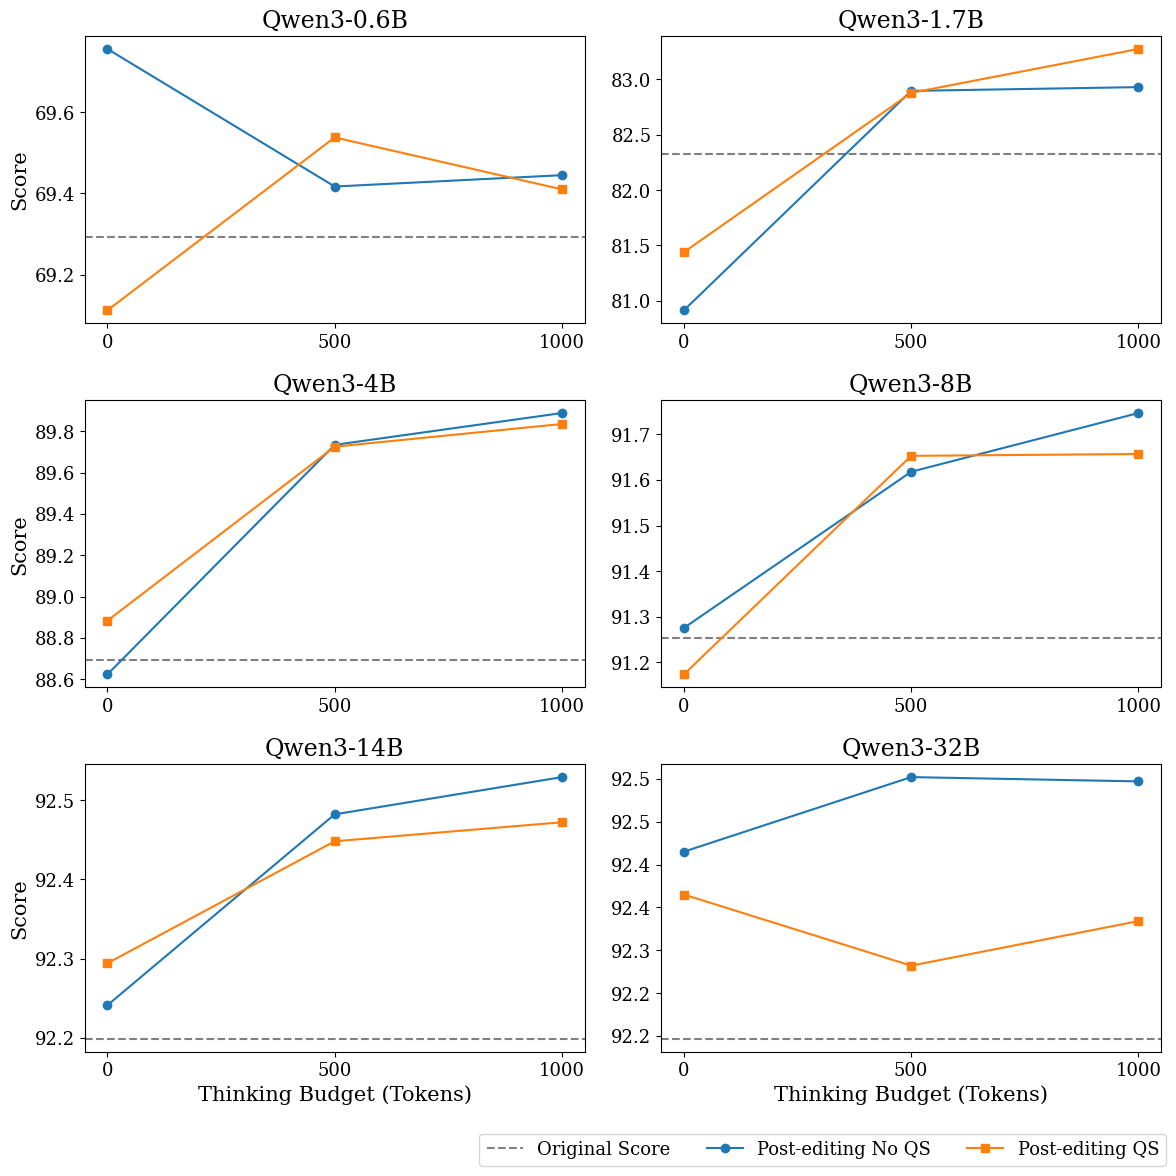

In [41]:
# 每个 Model 拼在一张图
plot_all_groups(
    df_grb_by_model,
    "Model",
    "Model",
    ncols=2,
    # save_path="post_editing_compare_by_model_grb.png",
    save_path="post_editing_compare_by_model_grb.pdf",
)

# 每个 Task 拼在一张图
# plot_all_groups(df_by_task, "Task", "Task", ncols=3)

#### GRF

In [17]:
# visualize_qwen_models_comparison(
#     dfs_original_by_grf,
#     dfs_post_editing_by_grf,
#     dfs_post_editing_without_quality_score_by_grf,
# )

In [33]:
df_grf = generate_improvement_table(
    dfs_original_by_grf,
    dfs_post_editing_by_grf,
    dfs_post_editing_without_quality_score_by_grf,
)
# print(improvement_df.to_string(index=False))
df_grf = df_grf[df_grf["Task"] != "WMT23-Biomedical-Sentence"].reset_index(drop=True)
df_grf.loc[df_grf["Task"] == "DRT-Gutenberg", "Task"] = "MetaphorTrans"
df_grf.loc[df_grf["Task"] == "LITEVAL-CORPUS", "Task"] = "LitEval-Corpus"
df_grf.loc[df_grf["Task"] == "WMT-Literary", "Task"] = "WMT24-Literary"
df_grf.loc[df_grf["Task"] == "WMT23-Biomedical-Doc", "Task"] = "WMT23-Biomedical"

# 1) 以 Task 聚合（平均所有模型）
df_grf_by_task = agg_and_annotate(df_grf, by="Task")

# 2) 以 Model 聚合（平均所有任务）
df_grf_by_model = agg_and_annotate(df_grf, by="Model")

In [34]:
for col in df_grf_by_model.columns:
    if col not in ["Model"]:
        df_grf_by_model[col] = df_grf_by_model[col].map(lambda x: f"{x:.3f}")

latex_str = df_grf_by_model.to_latex(
    index=False,  # 不输出行号
    escape=False,  # 保留列名中的 $_{Before}$ 这种 LaTeX 语法
    column_format="lccccccccccccc",  # 可根据列数调整对齐方式（这里假设 10 列，用 l + 9个c）
    longtable=False,  # 如果列特别多，可以改 True
    multicolumn=True,
    multicolumn_format="c",
)

print(latex_str)

\begin{tabular}{lccccccccccccc}
\toprule
Model & Original Score & Post-editing No QS (budget=0) & Δ Post-editing No QS (budget=0) & Post-editing No QS (budget=500) & Δ Post-editing No QS (budget=500) & Post-editing No QS (budget=1000) & Δ Post-editing No QS (budget=1000) & Post-editing QS (budget=0) & Δ Post-editing QS (budget=0) & Post-editing QS (budget=500) & Δ Post-editing QS (budget=500) & Post-editing QS (budget=1000) & Δ Post-editing QS (budget=1000) \\
\midrule
Qwen3-0.6B & 67.477 & 67.757 & 0.281 & 67.936 & 0.459 & 67.989 & 0.512 & 67.987 & 0.510 & 68.085 & 0.608 & 68.057 & 0.580 \\
Qwen3-1.7B & 81.727 & 79.159 & -2.568 & 81.988 & 0.261 & 82.305 & 0.578 & 80.260 & -1.467 & 82.445 & 0.718 & 82.730 & 1.003 \\
Qwen3-14B & 92.261 & 92.613 & 0.352 & 92.763 & 0.501 & 92.853 & 0.592 & 92.642 & 0.381 & 92.757 & 0.495 & 92.810 & 0.549 \\
Qwen3-32B & 92.256 & 92.767 & 0.511 & 92.923 & 0.667 & 92.864 & 0.608 & 92.816 & 0.560 & 92.768 & 0.512 & 92.899 & 0.643 \\
Qwen3-4B & 88.588 & 88.625

In [35]:
df_grf_by_model["model_size"] = df_grf_by_model["Model"].map(extract_model_size)
df_grf_by_model = df_grf_by_model.sort_values("model_size").drop(columns=["model_size"])
df_grf_by_model

,Model,Original Score,Post-editing No QS (budget=0),Δ Post-editing No QS (budget=0),Post-editing No QS (budget=500),Δ Post-editing No QS (budget=500),Post-editing No QS (budget=1000),Δ Post-editing No QS (budget=1000),Post-editing QS (budget=0),Δ Post-editing QS (budget=0),Post-editing QS (budget=500),Δ Post-editing QS (budget=500),Post-editing QS (budget=1000),Δ Post-editing QS (budget=1000)
0,Qwen3-0.6B,67.477,67.757,0.281,67.936,0.459,67.989,0.512,67.987,0.510,68.085,0.608,68.057,0.580
1,Qwen3-1.7B,81.727,79.159,-2.568,81.988,0.261,82.305,0.578,80.260,-1.467,82.445,0.718,82.730,1.003
4,Qwen3-4B,88.588,88.625,0.038,89.936,1.349,90.057,1.470,88.755,0.168,89.885,1.298,90.031,1.444
5,Qwen3-8B,91.208,90.440,-0.768,92.007,0.799,92.018,0.810,89.499,-1.709,92.051,0.843,91.933,0.725
2,Qwen3-14B,92.261,92.613,0.352,92.763,0.501,92.853,0.592,92.642,0.381,92.757,0.495,92.810,0.549
3,Qwen3-32B,92.256,92.767,0.511,92.923,0.667,92.864,0.608,92.816,0.560,92.768,0.512,92.899,0.643


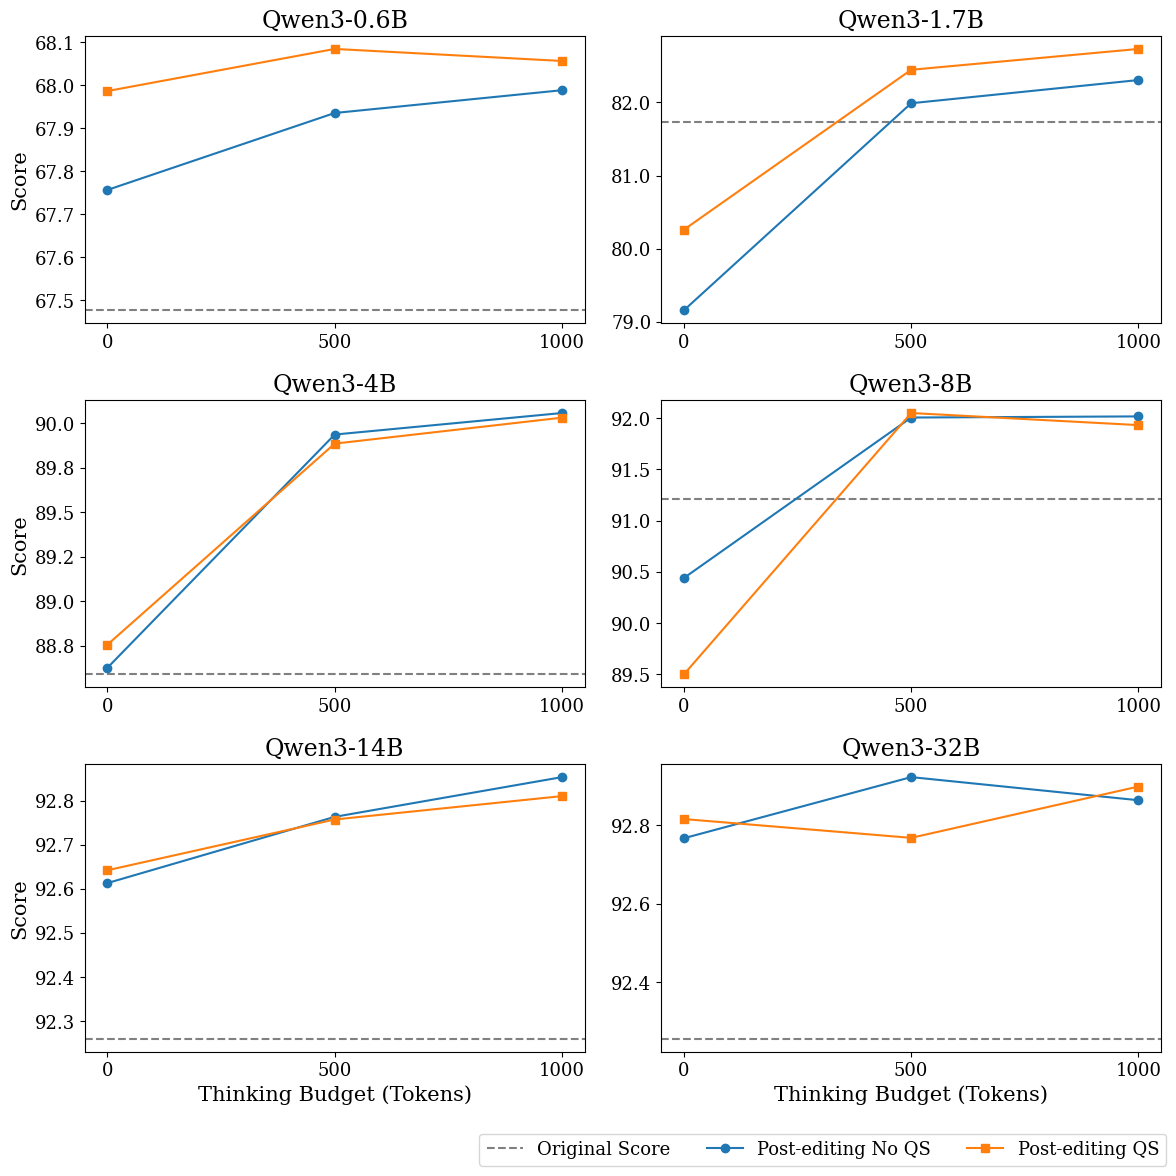

In [40]:
# 每个 Model 拼在一张图
plot_all_groups(
    df_grf_by_model,
    "Model",
    "Model",
    ncols=2,
    # save_path="post_editing_compare_by_model_grf.png",
    save_path="post_editing_compare_by_model_grf.pdf",
)

# 每个 Task 拼在一张图
# plot_all_groups(df_by_task, "Task", "Task", ncols=3)

#### GEA_5

In [22]:
# visualize_qwen_models_comparison(
#     dfs_original_by_gea_5,
#     dfs_post_editing_by_gea_5,
#     dfs_post_editing_without_quality_score_by_gea_5,
# )

In [23]:
# improvement_df = generate_improvement_table(
#     dfs_original_by_gea_5,
#     dfs_post_editing_by_gea_5,
#     dfs_post_editing_without_quality_score_by_gea_5,
# )
# # print(improvement_df.to_string(index=False))
# improvement_df

#### GEA_100

In [24]:
# visualize_qwen_models_comparison(
#     dfs_original_by_gea_100,
#     dfs_post_editing_by_gea_100,
#     dfs_post_editing_without_quality_score_by_gea_100,
# )

In [25]:
# improvement_df = generate_improvement_table(
#     dfs_original_by_gea_100,
#     dfs_post_editing_by_gea_100,
#     dfs_post_editing_without_quality_score_by_gea_100,
# )
# # print(improvement_df.to_string(index=False))
# improvement_df